<a href="https://colab.research.google.com/github/VKSi/2020_12_DataCompetitions_Course/blob/main/HW_7_ModelsTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Урок 7. Тюнинг гиперпараметров, построение ансамблей алгоритмов.

Чтобы было больше времени на выполнение курсовой работы, задание выполнить на наборе данных для соревнования:

Тестовая выборка - это выборка для применения модели и загрузки на ЛБ.

1. Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.     
2. Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.     
3. Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.     
4. Выполнить задание 2 для трех моделей.     
5. (опция) Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.     
6. (опция) Обучить алгоритмRandomForest (желательно подтюнить параметры) и добавить к построенным ранее моделям. Выполнить задание 5.

# Общая (подготовительная) часть

## Загрузка данных

In [ ]:
!pip install catboost

     |████████████████████████████████| 66.3MB 57kB/s 


In [ ]:
# !pip install lightgbm

In [ ]:
# !pip install xgboost

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import files, drive
import pickle
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
from typing import List, Tuple
import catboost as cb
import xgboost as xgb
import lightgbm as lgb

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
PATH = 'gdrive/My Drive/AI/GB/Kaggle/geekbrains-competitive-data-analysis/'
object_path = PATH + 'objects/'

In [ ]:
def save_obj(obj, name: str):
    path = object_path + name + '.pkl'
    with open(path, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    return path


def load_obj(name: str):
    with open(object_path + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [ ]:
train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'test.csv')
data = pd.read_csv(object_path + "data_bl.csv", index_col=0)  # Модель данных из baseline
cp = pd.read_csv(PATH + "client_profile.csv", index_col=0)  # Сырые данные ок лиентах 

In [ ]:
print("data.shape = {} rows, {} cols".format(*data.shape))

data.shape = 275234 rows, 54 cols


In [ ]:
train.columns = [col.lower() for col in train.columns]
test.columns = [col.lower() for col in test.columns]

In [ ]:
data.drop(columns=['target'], inplace=True)
data.drop(columns=['name_contract_type'], inplace=True)
if 'Unnamed: 0' in data.columns:
  data.drop('Unnamed: 0', axis='columns', inplace=True)

In [ ]:
AN = 'application_number'
ID ='application_number'
TARGET = 'target'

In [ ]:
data.tail(2)

,application_number,gender,childrens,total_salary,amount_credit,amount_annuity,education_level,family_status,region_population,age,days_on_last_job,own_car_age,flag_phone,flag_email,family_size,external_scoring_rating_1,external_scoring_rating_2,external_scoring_rating_3,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,bki_requests_count,bki_kurtosis,external_scoring_prod,external_scoring_weighted,external_scoring_rating_min,external_scoring_rating_max,external_scoring_rating_mean,external_scoring_rating_nanmedian,external_scoring_rating_var,ratio_credit_to_annuity,ratio_annuity_to_salary,ratio_credit_to_salary,ratio_annuity_to_age,ratio_credit_to_age,ratio_salary_to_age,ratio_salary_to_experience,ratio_credit_to_experience,ratio_annuity_to_experience,ratio_age_to_experience,ratio_salary_to_region_population,ratio_car_to_experience,ratio_car_to_age,expected_total_loss_1,expected_total_loss_2,expected_total_loss_3,expected_monthly_loss_1,expected_monthly_loss_2,expected_monthly_loss_3
275232,123631557,F,0.0,112500.0,350181.0,36769.5,Secondary / secondary special,Married,0.030755,20551.0,NaN,NaN,0.0,1.0,2.0,NaN,0.761376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.761376,0.761376,0.761376,0.761376,0.000000,9.523681,0.326840,3.112720,1.789183,17.039609,5.474186,NaN,NaN,NaN,NaN,3459.9375,NaN,NaN,NaN,266619.257702,NaN,NaN,27995.398940,NaN
275233,123433260,M,0.0,247500.0,1241437.5,36427.5,Secondary / secondary special,Married,0.018029,18853.0,6543.0,15.0,0.0,0.0,2.0,NaN,0.493617,0.546023,0.0,0.0,0.0,1.0,0.0,2.0,3.0,1.428571,NaN,NaN,0.493617,0.546023,0.519820,0.519820,0.000687,34.079679,0.147182,5.015909,1.932186,65.848273,13.127884,37.826685,189.735213,5.5674,2.8814,4462.1775,0.002293,0.000796,NaN,612794.525674,677853.672632,NaN,17981.229489,19890.260009


## Полезные функции из лекции

In [ ]:
def lightgbm_cross_validation(params, X, y, cv, categorical = None, early_stopping_rounds = 5000):
    """
    Кросс-валидация для модели lightgbm.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    if not categorical:
        categorical = "auto"

    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            eval_metric="auc", verbose=1000, early_stopping_rounds=early_stopping_rounds,
            categorical_feature=categorical
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds


def xgboost_cross_validation(params, X, y, cv, categorical = None, early_stopping_rounds=5000):
    """
    Кросс-валидация для модели xgboost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, encoders = [], {}
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        dtrain = xgb.DMatrix(x_train, y_train)
        dvalid = xgb.DMatrix(x_valid, y_valid)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            maximize=True,
            num_boost_round=10000,
            early_stopping_rounds=early_stopping_rounds,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            verbose_eval=1000,
        )
        oof_preds[valid_idx] = model.predict(dvalid)
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        estimators.append(model)

    return estimators, encoders, oof_preds

## Предобработка данных для возможности использования в LightGBM и XGBoost
* в основном из ноутбука data_wrangling_cp

In [ ]:
data_cb = data.copy()  # для категориального бустинга сохраняем не преобразованные данные

In [ ]:
REST_FEATURES = data.columns
INITIAL_FEATURES = REST_FEATURES.copy()

REST_FEATURES = list(set(REST_FEATURES) - set([ID]))

REST_FEATURES = list(set(REST_FEATURES) - set([TARGET]))
NUMERICAL_FEATURES = data[REST_FEATURES].select_dtypes(include=[np.number]).columns.to_list()
REST_FEATURES = list(set(REST_FEATURES) - set(NUMERICAL_FEATURES))
CATEGORICAL_FEATURES = REST_FEATURES

In [ ]:
CATEGORICAL_FEATURES

['family_status', 'gender', 'education_level']

In [ ]:
for feat in CATEGORICAL_FEATURES:
  print('*'*10)
  print(feat)
  print(data[feat].value_counts())

**********
family_status
Married                 143149
Single / not married     32888
Civil marriage           21687
Separated                14295
Widow                    11694
Unknown                      2
Name: family_status, dtype: int64
**********
gender
F      147444
M       76267
XNA         4
Name: gender, dtype: int64
**********
education_level
Secondary / secondary special    158887
Higher education                  54516
Incomplete higher                  7456
Lower secondary                    2736
Academic degree                     120
Name: education_level, dtype: int64


Уровень образования является ординальной величиной. Создадим соответствующий признак

In [ ]:
EDUCATION_LEVEL_dict = {'Lower secondary':1, 'Secondary / secondary special': 2, 'Incomplete higher':3, 'Higher education':4, 'Academic degree':5}
data['education_level__ordinal'] = data['education_level'].map(EDUCATION_LEVEL_dict)

In [ ]:
data['education_level__ordinal'].value_counts().sort_index()

1.0      2736
2.0    158887
3.0      7456
4.0     54516
5.0       120
Name: education_level__ordinal, dtype: int64

In [ ]:
data = data.drop(columns='education_level')

GENDER XNA скорее всего соответствует NA. Заменим эту запись, убрав лишнее значение категории

In [ ]:
data.loc[data.gender == 'XNA', 'gender'] = np.nan
data.loc[data.gender == 'M', 'gender'] = 0
data.loc[data.gender == 'F', 'gender'] = 1

In [ ]:
data.gender.value_counts()

1    147444
0     76267
Name: gender, dtype: int64

То же самое в FAMILY_STATUS

In [ ]:
data.loc[data.family_status == 'Unknown', 'family_status'] = np.nan

In [ ]:
data = pd.get_dummies(data, columns=['family_status'])


In [ ]:
data.head(5)

,application_number,gender,childrens,total_salary,amount_credit,amount_annuity,region_population,age,days_on_last_job,own_car_age,flag_phone,flag_email,family_size,external_scoring_rating_1,external_scoring_rating_2,external_scoring_rating_3,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,bki_requests_count,bki_kurtosis,external_scoring_prod,external_scoring_weighted,external_scoring_rating_min,external_scoring_rating_max,external_scoring_rating_mean,external_scoring_rating_nanmedian,external_scoring_rating_var,ratio_credit_to_annuity,ratio_annuity_to_salary,ratio_credit_to_salary,ratio_annuity_to_age,ratio_credit_to_age,ratio_salary_to_age,ratio_salary_to_experience,ratio_credit_to_experience,ratio_annuity_to_experience,ratio_age_to_experience,ratio_salary_to_region_population,ratio_car_to_experience,ratio_car_to_age,expected_total_loss_1,expected_total_loss_2,expected_total_loss_3,expected_monthly_loss_1,expected_monthly_loss_2,expected_monthly_loss_3,education_level__ordinal,family_status_Civil marriage,family_status_Married,family_status_Separated,family_status_Single / not married,family_status_Widow
0,123687442,0,1.0,157500.0,855000.0,25128.0,0.019101,15728.0,1719.0,11.0,0.0,0.0,3.0,0.700784,0.645914,0.716570,0.0,0.0,1.0,0.0,0.0,2.0,3.0,1.428571,0.324353,4.197193,0.645914,0.716570,0.687756,0.700784,9.169231e-04,34.025788,0.159543,5.428571,1.597660,54.361648,10.013988,91.623037,497.382199,14.617801,9.149506,3008.4075,0.006399,0.000699,599170.547652,552256.266546,612667.559305,17609.307043,16230.521013,18005.977111,2.0,0,1,0,0,0
1,123597908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
2,123526683,1,0.0,135000.0,1006920.0,42660.0,0.026392,21557.0,3618.0,NaN,1.0,0.0,2.0,NaN,0.682149,0.267869,0.0,0.0,0.0,7.0,0.0,4.0,11.0,0.539379,NaN,NaN,0.267869,0.682149,0.475009,0.475009,4.290708e-02,23.603376,0.316000,7.458667,1.978940,46.709653,6.262467,37.313433,278.308458,11.791045,5.958264,3562.9200,NaN,NaN,NaN,686869.876357,269722.588880,NaN,29100.493510,11427.288803,4.0,0,1,0,0,0
3,123710391,0,0.0,180000.0,518562.0,22972.5,0.031329,22338.0,NaN,NaN,0.0,0.0,2.0,NaN,0.171299,0.170446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,NaN,0.170446,0.171299,0.170873,0.170873,1.818800e-07,22.573164,0.127625,2.880900,1.028405,23.214343,8.058018,NaN,NaN,NaN,NaN,5639.2200,NaN,NaN,NaN,88829.188848,88386.882459,NaN,3935.167908,3915.573562,2.0,0,1,0,0,0
4,123590329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0


Посмотрим только на те данные, которые нам реально понадобятся для модели

In [ ]:
df = data[(data[AN].isin(train[AN].values)) | (data[AN].isin(test[AN].values))].sort_values(by=AN)

In [ ]:
df.head()

,application_number,gender,childrens,total_salary,amount_credit,amount_annuity,region_population,age,days_on_last_job,own_car_age,flag_phone,flag_email,family_size,external_scoring_rating_1,external_scoring_rating_2,external_scoring_rating_3,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,bki_requests_count,bki_kurtosis,external_scoring_prod,external_scoring_weighted,external_scoring_rating_min,external_scoring_rating_max,external_scoring_rating_mean,external_scoring_rating_nanmedian,external_scoring_rating_var,ratio_credit_to_annuity,ratio_annuity_to_salary,ratio_credit_to_salary,ratio_annuity_to_age,ratio_credit_to_age,ratio_salary_to_age,ratio_salary_to_experience,ratio_credit_to_experience,ratio_annuity_to_experience,ratio_age_to_experience,ratio_salary_to_region_population,ratio_car_to_experience,ratio_car_to_age,expected_total_loss_1,expected_total_loss_2,expected_total_loss_3,expected_monthly_loss_1,expected_monthly_loss_2,expected_monthly_loss_3,education_level__ordinal,family_status_Civil marriage,family_status_Married,family_status_Separated,family_status_Single / not married,family_status_Widow
47058,123423341,0,0.0,202500.0,406597.5,24700.5,0.018801,9461.0,637.0,NaN,1.0,0.0,1.0,0.083037,0.262949,0.139376,0.0,0.0,0.0,0.0,0.0,1.0,1.0,6.0,0.003043,0.84715,0.083037,0.262949,0.161787,0.139376,0.005646,16.461104,0.121978,2.007889,2.610771,42.976165,21.403657,317.896389,638.300628,38.776295,14.852433,3807.2025,NaN,NaN,33762.623349,106914.240440,56669.843749,2051.054613,6494.961715,3442.651456,2.0,0,0,0,1,0
196055,123423342,1,0.0,270000.0,1293502.5,35698.5,0.003541,16765.0,1188.0,NaN,1.0,0.0,2.0,0.311267,0.622246,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.311267,0.622246,0.466757,0.466757,0.024177,36.234085,0.132217,4.790750,2.129347,77.154936,16.104981,227.272727,1088.806818,30.049242,14.111953,956.0700,NaN,NaN,402625.045440,804876.465907,NaN,11111.776115,22213.240808,NaN,4.0,0,1,0,0,0
237570,123423343,0,0.0,67500.0,135000.0,6750.0,0.010032,19046.0,225.0,26.0,1.0,0.0,1.0,NaN,0.555912,0.729567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.555912,0.729567,0.642739,0.642739,0.007539,20.000000,0.100000,2.000000,0.354405,7.088102,3.544051,300.000000,600.000000,30.000000,84.648889,677.1600,0.115556,0.001365,NaN,75048.131258,98491.503245,NaN,3752.406563,4924.575162,2.0,0,0,0,1,0
239383,123423344,1,0.0,135000.0,312682.5,29686.5,0.008019,19005.0,3039.0,NaN,0.0,0.0,2.0,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.650442,0.650442,0.650442,0.650442,0.000000,10.532818,0.219900,2.316167,1.562036,16.452644,7.103394,44.422507,102.889931,9.768509,6.253702,1082.5650,NaN,NaN,NaN,203381.733859,NaN,NaN,19309.337242,NaN,2.0,1,0,0,0,0
6474,123423345,0,0.0,121500.0,513000.0,21865.5,0.028663,19932.0,3038.0,NaN,0.0,0.0,1.0,NaN,0.322738,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.322738,0.322738,0.322738,0.322738,0.000000,23.461618,0.179963,4.222222,1.097005,25.737508,6.095725,39.993417,168.861093,7.197334,6.560895,3482.5545,NaN,NaN,NaN,165564.741216,NaN,NaN,7056.834014,NaN,2.0,0,0,0,1,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275234 entries, 47058 to 186722
Data columns (total 56 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   application_number                  275234 non-null  int64  
 1   gender                              223711 non-null  object 
 2   childrens                           223715 non-null  float64
 3   total_salary                        223715 non-null  float64
 4   amount_credit                       223715 non-null  float64
 5   amount_annuity                      223704 non-null  float64
 6   region_population                   223715 non-null  float64
 7   age                                 223715 non-null  float64
 8   days_on_last_job                    183605 non-null  float64
 9   own_car_age                         76034 non-null   float64
 10  flag_phone                          223715 non-null  float64
 11  flag_email            

In [ ]:
data_un = pd.concat([train, test], axis=0)
data_un = data_un.reset_index(drop=True)

In [ ]:
data_un.head()

,application_number,target,name_contract_type
0,123687442,0.0,Cash
1,123597908,1.0,Cash
2,123526683,0.0,Cash
3,123710391,1.0,Cash
4,123590329,1.0,Cash


In [ ]:
data_un.name_contract_type.value_counts()

Cash           248983
Credit Card     26251
Name: name_contract_type, dtype: int64

In [ ]:
data_un = pd.get_dummies(data_un, columns=['name_contract_type'])

In [ ]:
data = data_un.merge(df, how="left", on="application_number")

In [ ]:
data = data.replace(np.inf, np.nan)
data = data.replace(-np.inf, np.nan)

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
to_imput = list(set(data.columns) - set([ID, TARGET]))
for feat in to_imput:
  mice_imputer = IterativeImputer()
  data[feat] = mice_imputer.fit_transform(data[[feat]])

In [ ]:
data = data.replace(np.inf, np.nan)
data = data.replace(-np.inf, np.nan)

In [ ]:
data[to_imput].isna().sum().sum()

0

In [ ]:
data_lb = data.copy()

In [ ]:
mask = data[TARGET].isnull()
features_to_drop = [AN, TARGET]

X_train = data[~mask].drop(features_to_drop, axis=1)
y_train = data.loc[~mask, TARGET]
X_test = data.loc[mask].drop(features_to_drop, axis=1)

In [ ]:
X_train.shape

(110093, 57)

In [ ]:
y_train.shape

(110093,)

In [ ]:
X_test.shape

(165141, 57)

# Задание 1:
Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.     

## Функция для расчета и сохранения сабмитов

In [ ]:
def submition(subm_name, estimators, X_test, test, ID, TARGET, xgbm=False):
  """
  Расчет и сохранение сабмитов.

  Parameters
  ----------
  subm_name: str
      Имя для сабмита.

  estimators: list
    Список с объектами обученной модели.

  X_test: pandas.core.frame.DataFrame
    Тестовая матрица признаков (без ID).

  test: pandas.core.frame.DataFrame
    Тестовая матрица признаков (c ID, необработанная).

  ID: str
    Название колонки с id

  TARGET: str
    Название колонки с таргетом

  Returns
  -------
  to_submit: pandas.core.frame.DataFrame
    Матрица для сабмита
  """
  if xgbm:
    dtest = xgb.DMatrix(X_test)
  proba = np.zeros((len(estimators), X_test.shape[0]))
  for i, est in enumerate(estimators):
    if xgbm:
      proba[i, :] = est.predict(dtest)
    else:
      proba[i, :] = est.predict_proba(X_test)[:, 1]
    print(f'estimator {i+1} results are ready')
  proba_test = np.mean(proba, axis = 0)
  to_submit = pd.DataFrame(columns=[ID, TARGET])
  to_submit[ID] = test[ID]
  to_submit[TARGET] = proba_test
  to_submit.to_csv(f'{object_path}subm_{subm_name}.csv', index=False)
  return to_submit

## LightGBM

In [ ]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'n_estimators': 10000,
    'learning_rate': 0.001,
    'max_depth': 10,
    'subsample': 0.7,
    'random_state': 42,
    'silent': -1,
    'verbose': -1
}

In [ ]:
cv_strategy = StratifiedKFold(n_splits=5)

In [ ]:
estimators, oof_preds = lightgbm_cross_validation(params=lgbm_params,
                                                  X=X_train,
                                                  y=y_train,
                                                  cv=cv_strategy,
                                                  categorical = None,
                                                  early_stopping_rounds = 500)

Sat Dec 12 16:13:15 2020, Cross-Validation, 110093 rows, 57 cols
Training until validation scores don't improve for 500 rounds.
[1000]	valid_0's auc: 0.711308	valid_0's binary_logloss: 0.26143
[2000]	valid_0's auc: 0.717472	valid_0's binary_logloss: 0.257255
[3000]	valid_0's auc: 0.722098	valid_0's binary_logloss: 0.255495
[4000]	valid_0's auc: 0.724156	valid_0's binary_logloss: 0.254752
[5000]	valid_0's auc: 0.725158	valid_0's binary_logloss: 0.254494
[6000]	valid_0's auc: 0.725341	valid_0's binary_logloss: 0.254314
Early stopping, best iteration is:
[5660]	valid_0's auc: 0.725827	valid_0's binary_logloss: 0.254359
Fold 1, Valid score = 0.72583
Training until validation scores don't improve for 500 rounds.
[1000]	valid_0's auc: 0.703125	valid_0's binary_logloss: 0.262273
[2000]	valid_0's auc: 0.709512	valid_0's binary_logloss: 0.258537
[3000]	valid_0's auc: 0.714245	valid_0's binary_logloss: 0.256653
[4000]	valid_0's auc: 0.716991	valid_0's binary_logloss: 0.255904
[5000]	valid_0's au

In [ ]:
save_obj(estimators, 'estimators_bl_lgbm')
save_obj(oof_preds, 'oof_preds_bl_lgbm')

'gdrive/My Drive/AI/GB/Kaggle/geekbrains-competitive-data-analysis/objects/oof_preds_bl_lgbm.pkl'

In [ ]:
oof_score = roc_auc_score(y_train, oof_preds)
print(f"OOF-score = {round(oof_score, 5)}")

OOF-score = 0.72578


In [ ]:
X_test.head(2)

,name_contract_type_Cash,name_contract_type_Credit Card,gender,childrens,total_salary,amount_credit,amount_annuity,region_population,age,days_on_last_job,own_car_age,flag_phone,flag_email,family_size,external_scoring_rating_1,external_scoring_rating_2,external_scoring_rating_3,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,bki_requests_count,bki_kurtosis,external_scoring_prod,external_scoring_weighted,external_scoring_rating_min,external_scoring_rating_max,external_scoring_rating_mean,external_scoring_rating_nanmedian,external_scoring_rating_var,ratio_credit_to_annuity,ratio_annuity_to_salary,ratio_credit_to_salary,ratio_annuity_to_age,ratio_credit_to_age,ratio_salary_to_age,ratio_salary_to_experience,ratio_credit_to_experience,ratio_annuity_to_experience,ratio_age_to_experience,ratio_salary_to_region_population,ratio_car_to_experience,ratio_car_to_age,expected_total_loss_1,expected_total_loss_2,expected_total_loss_3,expected_monthly_loss_1,expected_monthly_loss_2,expected_monthly_loss_3,education_level__ordinal,family_status_Civil marriage,family_status_Married,family_status_Separated,family_status_Single / not married,family_status_Widow
110093,1.0,0.0,0.0,0.0,117000.0,1125000.0,32895.0,0.028663,16007.0,2646.0,20.000000,0.0,0.0,2.0,0.502059,0.628266,0.510665,0.0,0.0,0.0,0.0,1.0,4.0,5.0,4.639906,0.143151,3.033967,0.628266,0.628266,0.628266,0.628266,0.000000,34.199726,0.281154,9.615385,2.055038,70.281752,7.309302,44.217687,425.170068,12.431973,6.049509,3353.571,0.007559,0.001249,322939.469562,706799.427892,313952.077049,14458.706591,20666.815272,13970.667374,2.0,0.0,1.0,0.0,0.0,0.0
110094,1.0,0.0,1.0,2.0,81000.0,312768.0,17095.5,0.019689,10315.0,459.0,12.033603,0.0,0.0,4.0,0.502059,0.578161,0.188490,0.0,0.0,1.0,0.0,0.0,2.0,3.0,1.428571,0.143151,3.033967,0.188490,0.578161,0.383325,0.383325,0.037961,18.295341,0.211056,3.861333,1.657344,30.321667,7.852642,176.470588,681.411765,37.245098,22.472767,1594.809,0.015426,0.000849,322939.469562,180830.265914,58953.494506,14458.706591,9883.951718,3222.322825,2.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
submition(subm_name='bl_lgbm_hw7', estimators=estimators, X_test=X_test, ID=ID, TARGET=TARGET)

0 estimator results are ready
1 estimator results are ready
2 estimator results are ready
3 estimator results are ready
4 estimator results are ready


### LB submition:
  **0.72976**

## XGBoost

In [ ]:
xgb_params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "auc",
    "eta": "0.05",
    "max_depth": 6,
    "gamma": 10,
    "subsample": 0.85,
    "colsample_bytree": 0.7,
    "colsample_bylevel": 0.632,
    "min_child_weight": 30,
    "alpha": 0,
    "lambda": 0,
    "nthread": 6,
    "random_seed": 42
}


In [ ]:
xgb_estimators, _, xgb_oof = xgboost_cross_validation(params=xgb_params,
                                                      X=X_train,
                                                      y=y_train,
                                                      cv=cv_strategy,
                                                      categorical = None,
                                                      early_stopping_rounds=500)

Sat Dec 12 16:47:50 2020, Cross-Validation, 110093 rows, 57 cols
[0]	train-auc:0.689013	valid-auc:0.683124
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 500 rounds.
Stopping. Best iteration:
[423]	train-auc:0.766225	valid-auc:0.727701

Fold 1, Valid score = 0.72644
[0]	train-auc:0.691644	valid-auc:0.678143
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 500 rounds.
[1000]	train-auc:0.782375	valid-auc:0.720219
Stopping. Best iteration:
[1188]	train-auc:0.786035	valid-auc:0.72046

Fold 2, Valid score = 0.71989
[0]	train-auc:0.689561	valid-auc:0.690513
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 500 rounds.
[1000]	train-auc:0.782119	valid-auc:0.731245
Stopping. Best iteration:
[1172]	train-auc:0.78536	valid-auc:0.732066

Fold 3, Valid 

In [ ]:
save_obj(xgb_estimators, 'estimators_bl_xgb')
save_obj(xgb_oof, 'oof_preds_bl_xgb')

'gdrive/My Drive/AI/GB/Kaggle/geekbrains-competitive-data-analysis/objects/oof_preds_bl_xgb.pkl'

In [ ]:
oof_score = roc_auc_score(y_train, xgb_oof)
print(f"OOF-score = {round(oof_score, 5)}")

OOF-score = 0.72831


In [ ]:
submition(subm_name='bl_xgb_hw7', estimators=xgb_estimators, X_test=X_test, test=test, ID=ID, TARGET=TARGET, xgbm=True)

estimator 1 results are ready
estimator 2 results are ready
estimator 3 results are ready
estimator 4 results are ready
estimator 5 results are ready


,application_number,target
0,123724268,0.070627
1,123456549,0.283316
2,123428178,0.153693
3,123619984,0.085141
4,123671104,0.016864
...,...,...
165136,123487967,0.085141
165137,123536402,0.055058
165138,123718238,0.085141
165139,123631557,0.013095


### XGB submition:
  **0.73424**

## Корреляции

In [ ]:
oof_preds_lgbm = load_obj('oof_preds_bl_lgbm')
oof_preds_xgb = load_obj('oof_preds_bl_xgb')
subm_lgbm = pd.read_csv(object_path + "subm_bl_lgbm_hw7.csv", index_col=0)
subm_xgb = pd.read_csv(object_path + "subm_bl_xgb_hw7.csv", index_col=0)

In [ ]:
oof_preds_lgbm[:2]

array([0.02046236, 0.0838986 ])

In [ ]:
oof_preds_xgb[:2]

array([0.01656037, 0.08380837])

In [ ]:
subm_lgbm.head(2)

,target
application_number,
123724268,0.057826
123456549,0.241536


In [ ]:
subm_xgb.head(2)

,target
application_number,
123724268,0.070627
123456549,0.283316


In [ ]:

print(f'Корреляция между моделями на тренировочном наборе = {round(np.corrcoef(x=oof_preds_lgbm, y=oof_preds_xgb)[0, 1], 3)}')

Корреляция между моделями на тренировочном наборе = 0.962


In [ ]:
print(f'Корреляция между моделями на тестовом наборе = {round(np.corrcoef(x=subm_lgbm.target.values, y=subm_xgb.target.values)[0, 1], 3)}')

Корреляция между моделями на тестовом наборе = 0.977


### Отличное значение корреляции для слияния

# Задание 2
Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.

## MEAN

### Расчет

In [ ]:
subm_mean = np.mean(np.array([subm_lgbm.target.values, subm_xgb.target.values]), axis=0)
to_submit = pd.DataFrame(columns=[ID, TARGET])
to_submit[ID] = test[ID]
to_submit[TARGET] = subm_mean
to_submit.to_csv(f'{object_path}subm_bl_mean(lgbm_xgb).csv', index=False)

In [ ]:
to_submit.head()

,application_number,target
0,123724268,0.064226
1,123456549,0.262426
2,123428178,0.155141
3,123619984,0.085101
4,123671104,0.018674


### XGB + LGBM mean submition:
  **0.73295**

Лучше, чем LGBM, но хуже чем XGB

## GMEAN

### Расчет

In [ ]:
from scipy.stats import gmean

In [ ]:
subm_gmean = gmean(np.array([subm_lgbm.target.values, subm_xgb.target.values]))
to_submit = pd.DataFrame(columns=[ID, TARGET])
to_submit[ID] = test[ID]
to_submit[TARGET] = subm_gmean
to_submit.to_csv(f'{object_path}subm_bl_gmean(lgbm_xgb).csv', index=False)

### XGB + LGBM gmean submition:
  **0.73313**

Лучше, чем LGBM, но хуже чем XGB. Лучше чем простое среднее

## Ранги

### Расчет

In [ ]:
from scipy.stats import rankdata

In [ ]:
scores = pd.DataFrame({'lgbm':subm_lgbm.target.values, 'xgb':subm_xgb.target.values})


In [ ]:
scores.head(2)

,lgbm,xgb
0,0.057826,0.070627
1,0.241536,0.283316


In [ ]:
scores_rank_gmean = gmean(scores.rank(axis=0), axis=1)
scores_rank_gmean = scores_rank_gmean/np.max(scores_rank_gmean)
scores_rank_gmean

array([0.47380934, 0.96750954, 0.89152354, ..., 0.66301793, 0.05075414,
       0.34080279])

In [ ]:
len(scores_rank_gmean)

165141

In [ ]:
to_submit = pd.DataFrame(columns=[ID, TARGET])
to_submit[ID] = test[ID]
to_submit[TARGET] = scores_rank_gmean
to_submit.to_csv(f'{object_path}subm_bl_rank_gmean(lgbm_xgb).csv', index=False)

### LGBM + XGB rank submition

**0.73262**

Хуже чем просто gmean

# Задание 3
Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей

Обученная модель с OOF прогнозами Baseline у нас есть.     
Попробуем обучить модель с учетом заполнения пропусков и сравнить результаты

## CatBoost модель

In [ ]:
def catboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    X[categorical] = X[categorical].astype(str)

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = cb.CatBoostClassifier(**params)
        model.fit(
            x_train, y_train, categorical,
            eval_set=[(x_train, y_train), (x_valid, y_valid)]
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

In [ ]:
cb_params = {
    "n_estimators": 10000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 1000,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 500,
    "thread_count": 6,
    "random_seed": 42
}

In [ ]:
cv_strategy = StratifiedKFold(n_splits=5)

In [ ]:
CATEGORICAL_FEATURES = list()
for feat in X_train.columns:
  if X_train[feat].nunique() < 10:
    CATEGORICAL_FEATURES.append(feat)
CATEGORICAL_FEATURES

['name_contract_type_Cash',
 'name_contract_type_Credit Card',
 'gender',
 'flag_phone',
 'flag_email',
 'amt_req_credit_bureau_hour',
 'amt_req_credit_bureau_day',
 'amt_req_credit_bureau_week',
 'education_level__ordinal',
 'family_status_Civil marriage',
 'family_status_Married',
 'family_status_Separated',
 'family_status_Single / not married',
 'family_status_Widow']

In [ ]:
CATEGORICAL_FEATURES = list(set(CATEGORICAL_FEATURES) - set(['amt_req_credit_bureau_hour', 'amt_req_credit_bureau_day', 'amt_req_credit_bureau_week']))
CATEGORICAL_FEATURES

['name_contract_type_Cash',
 'education_level__ordinal',
 'flag_phone',
 'family_status_Separated',
 'family_status_Civil marriage',
 'family_status_Widow',
 'gender',
 'family_status_Single / not married',
 'family_status_Married',
 'flag_email',
 'name_contract_type_Credit Card']

In [ ]:
X_train_catb = X_train.copy()
X_test_catb = X_test.copy()
for feat in CATEGORICAL_FEATURES:
  X_train_catb[feat] = (X_train_catb[feat].astype('float')*10000//10/1000).astype('str')
  X_test_catb[feat] = (X_test_catb[feat].astype('float')*10000//10/1000).astype('str')

In [ ]:
for feat in CATEGORICAL_FEATURES:
  print(set(X_train_catb[feat].unique())==set(X_test_catb[feat].unique()))

True
True
True
True
True
True
True
True
True
True
True


In [ ]:
estimators, oof_preds = catboost_cross_validation(params=cb_params,
                                                  X=X_train,
                                                  y=y_train,
                                                  cv=cv_strategy,
                                                  categorical=CATEGORICAL_FEATURES)

Sat Dec 12 21:42:08 2020, Cross-Validation, 110093 rows, 57 cols
0:	test: 0.6449263	test1: 0.6451372	best: 0.6451372 (0)	total: 232ms	remaining: 38m 39s
1000:	test: 0.7441769	test1: 0.7212424	best: 0.7213285 (991)	total: 3m 25s	remaining: 30m 49s
2000:	test: 0.7571456	test1: 0.7228765	best: 0.7230176 (1963)	total: 6m 37s	remaining: 26m 30s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.723545184
bestIteration = 2210

Shrink model to first 2211 iterations.
Fold 1, Valid score = 0.72355
0:	test: 0.6467076	test1: 0.6378924	best: 0.6378924 (0)	total: 232ms	remaining: 38m 37s
1000:	test: 0.7441911	test1: 0.7176423	best: 0.7177786 (958)	total: 3m 25s	remaining: 30m 48s
2000:	test: 0.7630682	test1: 0.7191803	best: 0.7194737 (1577)	total: 6m 48s	remaining: 27m 12s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7194737494
bestIteration = 1577

Shrink model to first 1578 iterations.
Fold 2, Valid score = 0.71947
0:	test: 0.6446685	test1: 0.6460924	best

In [ ]:
save_obj(estimators, 'estimators_bl_catb')
save_obj(oof_preds, 'oof_preds_bl_catb')

'gdrive/My Drive/AI/GB/Kaggle/geekbrains-competitive-data-analysis/objects/oof_preds_bl_catb.pkl'

In [ ]:
oof_score = roc_auc_score(y_train, oof_preds)
print(f"OOF-score = {round(oof_score, 5)}")

OOF-score = 0.72477


Вообще-то результат получился чуть хуже, чем в базовой модели, но не очень существенно.

In [ ]:
subm_catb = submition(subm_name='bl_catb_hw7', estimators=estimators, X_test=X_test_catb, test=test, ID=ID, TARGET=TARGET)

estimator 1 results are ready
estimator 2 results are ready
estimator 3 results are ready
estimator 4 results are ready
estimator 5 results are ready


### CatBoost submition:
**0.72603**
На LB результат получился чуть-лучше, чем для базовой модели

## Корреляции

In [ ]:
oof_preds_bl = load_obj('oof_preds_bl')
oof_preds_lgbm = load_obj('oof_preds_bl_lgbm')
oof_preds_xgb = load_obj('oof_preds_bl_xgb')
oof_preds_catb = load_obj('oof_preds_bl_catb')

In [ ]:
subm_lgbm = pd.read_csv(object_path + "subm_bl_lgbm_hw7.csv", index_col=0)
subm_xgb = pd.read_csv(object_path + "subm_bl_xgb_hw7.csv", index_col=0)
subm_catb = pd.read_csv(object_path + "subm_bl_catb_hw7.csv", index_col=0)
subm_bl = pd.read_csv(object_path + "subm_baseline.csv", index_col=0)

In [ ]:
def pred_corr(scores):
  corr = scores_train.corr()
  mask = np.zeros_like(corr, dtype=np.bool)
  mask[np.triu_indices_from(mask)] = True
  fig, axes = plt.subplots(1, 1, figsize=(10, 10))
  sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)
  plt.show()

In [ ]:
scores_train = pd.DataFrame({'lgbm':oof_preds_lgbm, 'xgb':oof_preds_xgb, 'catb':oof_preds_catb, 'bl':oof_preds_bl})

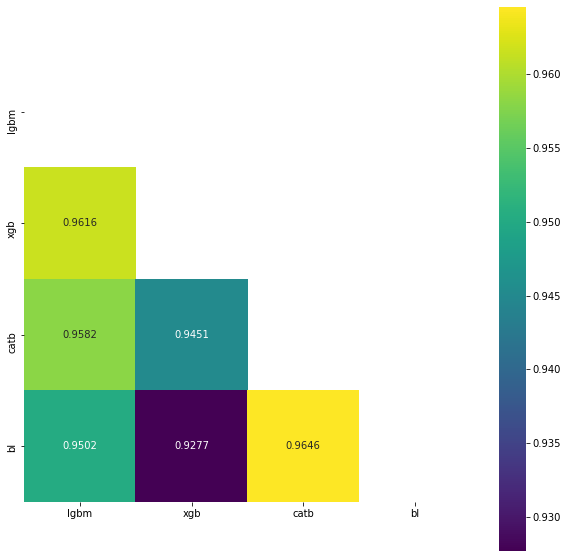

In [ ]:
pred_corr(scores=scores_train)

Корреляция достаточно низкая. И результат у catboost был далектовато вниз. Наверное, мешать не стоит

In [ ]:
scores_test = pd.DataFrame({'lgbm':subm_lgbm.target.values, 'xgb':subm_xgb.target.values, 'catb':subm_catb.target.values, 'bl':subm_bl.TARGET.values})

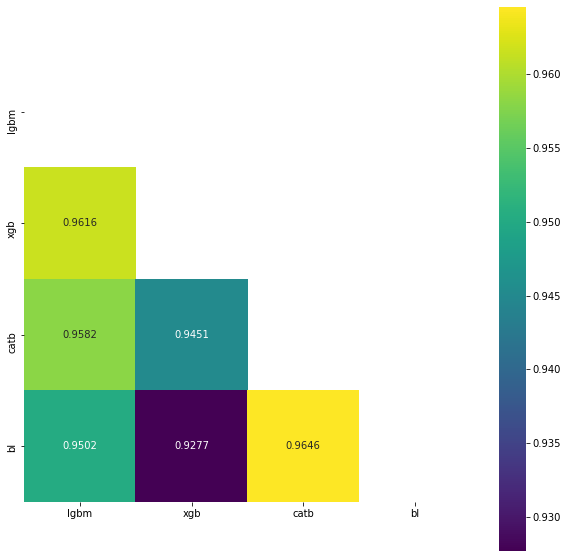

In [ ]:
pred_corr(scores=scores_test)

Та же история. Корреляции достаточно низкие. Скорее всего сабмит ухудшит результат и устойчивость модели

# Задание 4
Выполнить задание 2 для трех моделей

In [ ]:
scores_train_mean = scores_train.mean(axis=1)
score = roc_auc_score(y_train.values, scores_train_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7288


In [ ]:
scores_test_mean = scores_test.mean(axis=1)

In [ ]:
scores_train_gmean = gmean(scores_train, axis=1)
score = roc_auc_score(y_train.values, scores_train_gmean)
print(f"Score = {round(score, 4)}")

Score = 0.7288


In [ ]:
scores_test_gmean = gmean(scores_test, axis=1)

In [ ]:
scores_train_rank_mean = scores_train.rank().mean(axis=1)
score = roc_auc_score(y_train.values, scores_train_rank_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7286


In [ ]:
scores_train_rank_gmean = gmean(scores_train.rank(), axis=1)
score = roc_auc_score(y_train.values, scores_train_rank_gmean)
print(f"Score = {round(score, 4)}")

Score = 0.7286


Попробуем отсабмитить scores_test_gmean

In [ ]:
to_submit = pd.DataFrame(columns=[ID, TARGET])
to_submit[ID] = test[ID]
to_submit[TARGET] = scores_test_gmean
to_submit.to_csv(f'{object_path}subm_bl_gmean(lgbm_xgb_catb_bl).csv', index=False)

### XGB + LGBM + CATB + BL gmean submition:
  **0.73138**

Хуже, чем чистый XGB и хуже, чем gmean(LGBM, XGB)

# Задание 5
(опция) Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.

## Загрузка данных (ноутбук выполнялся в разные дни)

In [ ]:
oof_preds_bl = load_obj('oof_preds_bl')
oof_preds_lgbm = load_obj('oof_preds_bl_lgbm')
oof_preds_xgb = load_obj('oof_preds_bl_xgb')
oof_preds_catb = load_obj('oof_preds_bl_catb')

In [ ]:
subm_lgbm = pd.read_csv(object_path + "subm_bl_lgbm_hw7.csv", index_col=0)
subm_xgb = pd.read_csv(object_path + "subm_bl_xgb_hw7.csv", index_col=0)
subm_catb = pd.read_csv(object_path + "subm_bl_catb_hw7.csv", index_col=0)
subm_bl = pd.read_csv(object_path + "subm_baseline.csv", index_col=0)

In [ ]:
scores_train = pd.DataFrame({'lgbm':oof_preds_lgbm, 'xgb':oof_preds_xgb, 'catb':oof_preds_catb, 'bl':oof_preds_bl})

In [ ]:
scores_test = pd.DataFrame({'lgbm':subm_lgbm.target.values, 'xgb':subm_xgb.target.values, 'catb':subm_catb.target.values, 'bl':subm_bl.TARGET.values})

In [ ]:
scores_train.head(2)

,lgbm,xgb,catb,bl
0,0.020462,0.016560,0.025331,0.022107
1,0.083899,0.083808,0.084152,0.085708


In [ ]:
y_train.head(2)

0    0.0
1    1.0
Name: target, dtype: float64

## Линейная модель для всех 4-х моделей

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
stacking_lr = LogisticRegression(class_weight='balanced', random_state=42)
stacking_lr.fit(scores_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
stacking_lr.coef_

array([[ 1.85415618,  4.69711051, -0.46373303,  4.82339419]])

In [ ]:
stacking_lr.intercept_[0]

-1.0935345076542236

In [ ]:
(np.array(scores_train)*stacking_lr.coef_[0]).sum(axis=1)

0.040635207588664915

In [ ]:
scores_train_np = (np.array(scores_train)*stacking_lr.coef_[0]).sum(axis=1)
scores_train_np = scores_train_np/scores_train_np.max()
scores_train['stacking_lr'] = scores_train_np

In [ ]:
scores_train.head(2)

,lgbm,xgb,catb,bl,stacking_lr
0,0.020462,0.016560,0.025331,0.022107,0.027410
1,0.083899,0.083808,0.084152,0.085708,0.120202


In [ ]:
score = roc_auc_score(y_train.values, scores_train_np)
print(f"Score = {round(score, 4)}")

Score = 0.7291


Чуть выше чем чем на необученных вариантах

In [ ]:
scores_test_np = (np.array(scores_test)*stacking_lr.coef_[0]).sum(axis=1)
scores_test_np = scores_test_np/scores_test_np.max()

In [ ]:
  to_submit = pd.DataFrame(columns=[ID, TARGET])
  to_submit[ID] = test[ID]
  to_submit[TARGET] = scores_test_np
  to_submit.to_csv(f'{object_path}subm_bl_stacking_lr_hw7.csv', index=False)

## Submit
**0.73265**

## Попробуем то же самое но только для двух моделей

In [ ]:
stacking_lr_2 = LogisticRegression(class_weight='balanced', random_state=42)
stacking_lr_2.fit(scores_train[['lgbm', 'xgb']], y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
scores_train_np_2 = (np.array(scores_train[['lgbm', 'xgb']])*stacking_lr_2.coef_[0]).sum(axis=1)
scores_train_np_2 = scores_train_np_2/scores_train_np_2.max()

In [ ]:
score = roc_auc_score(y_train.values, scores_train_np_2)
print(f"Score = {round(score, 4)}")

Score = 0.7288


### Не лучше. Сабмитить не буду

## Может быть дурацкая идея, но хочется попробовать отлинеить геометрию

In [ ]:
scores_train_repr = 1/scores_train
scores_train_repr.head(2)

,lgbm,xgb,catb,bl,stacking_lr
0,48.870208,60.385110,39.478062,45.234282,36.483023
1,11.919150,11.931982,11.883279,11.667546,8.319354


In [ ]:
stacking_lr_3 = LogisticRegression(class_weight='balanced', random_state=42)
stacking_lr_3.fit(scores_train_repr[['lgbm', 'xgb', 'bl']], y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
stacking_lr_3.coef_

array([[-0.02226481, -0.00955765, -0.03115728]])

In [ ]:
scores_train_np_3 = (np.array(scores_train_repr[['lgbm', 'xgb', 'bl']])*stacking_lr_3.coef_[0]).sum(axis=1)
scores_train_np_3 = -1/scores_train_np_3
scores_train_np_3 = scores_train_np_3/scores_train_np_3.max()
scores_train_np_3

array([0.030145  , 0.12475147, 0.08425819, ..., 0.1239141 , 0.05195994,
       0.10198822])

In [ ]:
score = roc_auc_score(y_train.values, scores_train_np_3)
print(f"Score = {round(score, 4)}")

Score = 0.7283


### Кажется, не прокатило (((   )))

# Задание 6
(опция) Обучить алгоритмRandomForest (желательно подтюнить параметры) и добавить к построенным ранее моделям. Выполнить задание 5.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
def rfc_cross_validation(params, X, y, cv):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = RandomForestClassifier(**params)
        model.fit(
            X=x_train, y=y_train
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

In [ ]:
params_rfc = {'class_weight':'balanced',
              'n_estimators':250,
              'max_depth':8}

In [ ]:
cv_strategy = StratifiedKFold(n_splits=5)

In [ ]:
estimators, oof_preds = rfc_cross_validation(params=params_rfc,
                                             X=X_train,
                                             y=y_train,
                                             cv=cv_strategy)

Sun Dec 13 19:48:59 2020, Cross-Validation, 110093 rows, 57 cols
Fold 1, Valid score = 0.71117
Fold 2, Valid score = 0.70554
Fold 3, Valid score = 0.71468
Fold 4, Valid score = 0.70713
Fold 5, Valid score = 0.72055
Score by each fold: [0.71117, 0.70554, 0.71468, 0.70713, 0.72055]


In [ ]:
save_obj(estimators, 'estimators_bl_rfc')
save_obj(oof_preds, 'oof_preds_bl_rfc')

'gdrive/My Drive/AI/GB/Kaggle/geekbrains-competitive-data-analysis/objects/oof_preds_bl_rfc.pkl'

In [ ]:
oof_score = roc_auc_score(y_train, oof_preds)
print(f"OOF-score = {round(oof_score, 5)}")

OOF-score = 0.71144


Маловато будет. Мешать с предыдущими точно не стоит. Нужно тюнить параметры

In [ ]:
!pip install hyperopt --upgrade

     |████████████████████████████████| 972kB 5.4MB/s 
  Found existing installation: hyperopt 0.1.2
    Uninstalling hyperopt-0.1.2:
      Successfully uninstalled hyperopt-0.1.2


In [ ]:
from functools import partial
from hyperopt import hp, fmin, tpe, space_eval, Trials, STATUS_OK

In [ ]:
from sklearn.model_selection import cross_val_score
def acc_model(params):
    clf = RandomForestClassifier(**params)
    return cross_val_score(clf,
                           X_train,
                           y_train,
                           cv=5,
                           scoring='roc_auc').mean()

param_space = {
    'class_weight':'balanced',
    'max_depth': hp.choice('max_depth', range(1,50)),
    'max_features': hp.choice('max_features', range(1, len(X_train.columns))),
    'n_estimators': hp.choice('n_estimators', range(1,500)),
    'criterion': hp.choice('criterion', ["gini", "entropy"])}

best = 0
def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
    print ('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=100, trials=trials)
print ('best:')
print (best)

new best:
0.7076186545477932
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'max_features': 40, 'n_estimators': 392}
new best:
0.7076186545477932
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 30, 'max_features': 35, 'n_estimators': 338}
new best:
0.7076186545477932
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 18, 'max_features': 45, 'n_estimators': 295}
new best:
0.7076186545477932
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 19, 'max_features': 7, 'n_estimators': 104}
new best:
0.7076186545477932
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 1, 'max_features': 3, 'n_estimators': 58}
new best:
0.7076186545477932
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 17, 'max_features': 20, 'n_estimators': 224}
new best:
0.7076186545477932
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 29, 'max_features': 34, 'n_estimators': 233}
new best:
0.7076186545477932
{'class